## Tutorials in pyro

### Tutorial 1

In [ ]:
import torch

import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
%matplotlib inline

# Define a normal distribution
loc = 0.   # mean zero
scale = 1. # unit variance
normal = dist.Normal(loc, scale) # create a normal distribution object

# Sample from the distribution
x = normal.sample() # draw a sample from N(0,1)
print("sample", x)

# Ask what is the probability of a sample under that distribution
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

# normal.log_prob can bu used to plot the log_PDF
x=list()
logp=list()
for n in range(-100,100):
    tmp=n*0.1
    x.append(tmp)
    logp.append(normal.log_prob(tmp).item())
plt.plot(x,logp)

In [ ]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', dist.Normal(expected_sales, 10.0))
    return ice_cream.item(),cloudy, temp

for _ in range(3):
    print(weather())

for _ in range(3):
    print(ice_cream_sales())
    
    

Procedurally, weather() is a non-deterministic Python callable that returns two random samples. Because the randomness is invoked with pyro.sample, however, it is much more than that. In particular weather() specifies a joint probability distribution over two named random variables: cloudy and temp. As such, it defines a probabilistic model that we can reason about using the techniques of probability theory.

In [ ]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), dist.Bernoulli(p))
    if x.item() == 0:
        return x
    else:
        return x + geometric(p, t + 1)

print(geometric(0.99))

In [ ]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    print(type(fn)) # I have created a lambda function 
    # It takes a scale and returns normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.32))

## Tutorial 2

In [1]:
import torch

import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def scale(guess):
    # Prior 
    true_weight = pyro.sample("weight", dist.Normal(guess, 1.0)) 
    # Likelyhood  
    measured_weight = pyro.sample("measurement", dist.Normal(true_weight, 0.75)) 
    return measured_weight

print(type(scale))

<class 'function'>


average std= 1.231380834971677


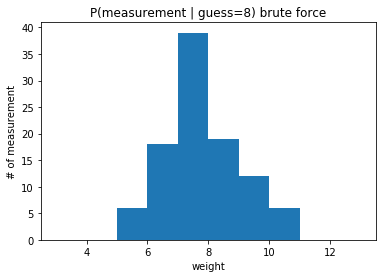

In [11]:
# Brute force approach.
# Check the behavior of my model.
# I run the model forward for a given value of guess

# The marginal distribution concentrates around the data
std_list1=list()
for _ in range(100):
    exp1=list()
    for _ in range(100):
        exp1.append(scale(8).item())
    #print("mean -> ",np.mean(exp1),"std-> ",np.std(exp1))
    std_list1.append(np.std(exp1))

print("average std=",np.mean(std_list1))
plt.hist(exp1, range=(3.0, 13.0))
plt.title("P(measurement | guess=8) brute force")
plt.xlabel("weight")
plt.ylabel("# of measurement");

In [8]:
# This is method based on inportance sampling
posterior = pyro.infer.Importance(scale, num_samples=100)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(8.0))

average std= 1.0941039173469091


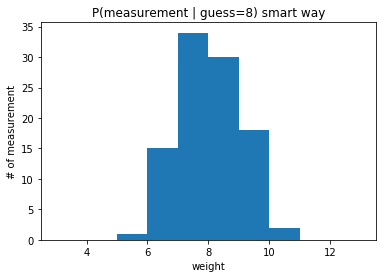

In [10]:
# The marginal distribution concentrates around the data
std_list2=list()
for _ in range(100):
    exp2=list()
    for _ in range(100):
        exp2.append(marginal().item())
    #print("mean -> ",np.mean(exp2),"std-> ",np.std(exp2))
    std_list2.append(np.std(exp2))

print("average std=",np.mean(std_list2))
plt.hist(exp2, range=(3.0, 13.0))
plt.title("P(measurement | guess=8) smart way")
plt.xlabel("weight")
plt.ylabel("# of measurement");

In [13]:
# That's nice but what if we want to plot 
# the posterior "P(measurement | guess=8, data=20)"

obs=torch.rand(10)

<class 'function'>
10.284226446151733
0.04785616957422706


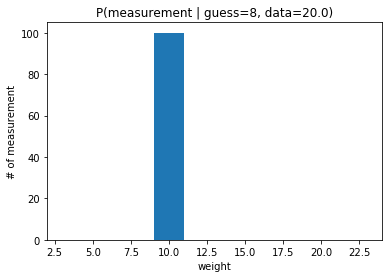

In [12]:
conditioned_scale = pyro.condition(scale, data={"measurement": 20.0})

print(type(conditioned_scale))

posterior = pyro.infer.Importance(conditioned_scale, num_samples=100)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(8.0), sites="weight")


exp2=list()
for _ in range(100):
    exp2.append(marginal().item())
    
# The marginal distribution concentrates around the data
print(np.mean(exp2))
print(np.std(exp2))
plt.hist(exp2, range=(3.0, 23.0))
plt.title("P(measurement | guess=8, data=20.0)")
plt.xlabel("weight")
plt.ylabel("# of measurement");

In [ ]:
# That's nice but what if we want to plot 
# the posterior "P(measurement | guess=8, data=[a,x,z,c,d,s])"

def scale_5(guess):
    # Prior 
    true_weight = pyro.sample("weight", dist.Normal(guess, 1.0)) 
    # Likelyhood
    m=list()
    for i in range(5):
        m.append(pyro.sample("m_"+str(i), dist.Normal(true_weight, 0.75)).item()) 
    return m

obs={"m_0" : 12, "m_1" : 13, "m_2" : 14, "m_3" : 15 ,"m_4" : 16 }

conditioned_scale_5 = pyro.condition(scale_5, data=obs)

posterior = pyro.infer.Importance(conditioned_scale, num_samples=100)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(8.0), sites="weight")


exp3=list()
for _ in range(100):
    exp3.append(marginal().item())
    

# The marginal distribution concentrates around the data
print(np.mean(exp3))
print(np.std(exp3))
plt.hist(exp2, range=(3.0, 23.0))
plt.title("P(measurement | guess=8, data=obs)")
plt.xlabel("weight")
plt.ylabel("# of measurement");

Although we could write out the exact posterior distribution for scale, in general it is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function. What we can do instead is use the top-level function pyro.param to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation. This approach to approximate posterior inference is called variational inference.